# Introduction

The goal of this notebook is to give an example of how a scientist could load the HOTS Shipboard ADCP data into a python environment for analysis use.

1. Setup/bookkeeping
2. Then we show some common plots that may be desired.
3. Then we do a time series comparison

## Next Steps/Uses
For a user 
* Find an interesting trend in the data you want to explore
* Learn more about ocean currents via shipboard ADCP data
* Explore more data sets like the ones found in the discussion for the dataset https://www.kaggle.com/datasets/davidvadnais/hawaii-ocean-times-series-shipboard-adcp-data/discussion/543470


## Linked references/Further reading
**This is the main document we are pulling from**<br>
Julia M Hummon, et al. CODAS+UHDAS Documentation. 282:c289b3782d3a, Zenodo, 22 Sept. 2023, doi:10.5281/zenodo.8371260.

**Disclaimer**
Im not a regular R programmer and I didnt look up any best practices before wrting this code. 


# 1. Setup

In [1]:
library(tidyverse) # metapackage of all tidyverse packages

install.packages("ncdf4")
library(ncdf4)
library(here) 

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     


── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



here() starts at /kaggle/working



In [2]:
# Define parameters
data_dir <- "/kaggle/input/go-ship-shipboard-adcp-data/"
nc_dir <- "/contour/"
desired_file_ending <- "_short.nc"

# List directories in the data directory
directories <- list.dirs(data_dir, full.names = FALSE, recursive = FALSE)

# Initialize a set to store unique cruise tracks
cruise_track_set <- character(0)

# Get cruise tracks
for (directory in directories) {
  # Split the directory name by underscores
  parts <- unlist(strsplit(directory, "_"))
  if (length(parts) > 1) {
    cruise_track_set <- unique(c(cruise_track_set, parts[2]))
  }
}

# Initialize a list to store datasets and metadata
datasets_files <- list()

# Load data
for (directory in directories) {
  parts <- unlist(strsplit(directory, "_"))
  cruise_track <- parts[2]
  year <- parts[1]

  # Construct the file location for the contour directory
  file_loc <- paste0(data_dir, directory, nc_dir)

  # Check if the contour directory exists
  if (dir.exists(file_loc)) {
    all_nc_files <- list.files(file_loc)
    short_file_path <- NULL
    for (file in all_nc_files) {
      if (endsWith(file, desired_file_ending)) {
        short_file_path <- file.path(file_loc, file)
        break # Found the desired file, no need to continue searching
      }
    }

    if (!is.null(short_file_path)) {
      tryCatch({
        nc_file <- nc_open(short_file_path)
        profile <- basename(short_file_path)
        datasets_files[[length(datasets_files) + 1]] <- list(nc_file = nc_file, cruise_track = cruise_track, year = year, profile = profile)
      }, error = function(e) {
        cat(sprintf("Error opening file: %s - %s\n", short_file_path, e$message))
      })
    }
  } else {
    # Handle potential 'n sonars' subdirectories
    sonars_dir <- file.path(data_dir, directory)
    sonar_dirs <- list.dirs(sonars_dir, full.names = FALSE, recursive = FALSE)

    for (sonar in sonar_dirs) {
      file_loc <- file.path(data_dir, directory, sonar, nc_dir)
      if (dir.exists(file_loc)) {
        all_nc_files <- list.files(file_loc)
        short_file_path <- NULL
        for (file in all_nc_files) {
          if (endsWith(file, desired_file_ending)) {
            short_file_path <- file.path(file_loc, file)
            break
          }
        }

        if (!is.null(short_file_path)) {
          tryCatch({
            nc_file <- nc_open(short_file_path)
            profile <- basename(short_file_path)
            datasets_files[[length(datasets_files) + 1]] <- list(nc_file = nc_file, cruise_track = cruise_track, year = year, profile = profile)
          }, error = function(e) {
            cat(sprintf("Error opening file: %s - %s\n", short_file_path, e$message))
          })
        }
      }
    }
  }
}

In [3]:
if (length(datasets_files) > 0 && length(datasets_files[[1]]) > 0) {
  dataset <- datasets_files[[1]]$nc_file # Access the NetCDF file object

  # Print the variable names in the NetCDF file
  print(names(dataset$var))

  # Get the time variable name 
  time_var_name <- "time"

  # Check if the time variable exists
  if (time_var_name %in% names(dataset$var)) {
    time_var <- dataset$var[[time_var_name]]

    # Get the time values
    time_values <- ncvar_get(dataset, time_var_name)

    # Get the units attribute of the time variable
    time_units <- ncatt_get(dataset, time_var_name, "units")$value

    # Try to extract the year from the first time value based on the units
    year <- NA # Initialize year

    if (!is.null(time_values) && length(time_values) > 0) {
      if (grepl("days since", time_units)) {
        origin_str <- sub("days since ", "", time_units)
        origin_date <- as.POSIXct(origin_str, tz = "UTC")
        first_time <- origin_date + time_values[1] * 24 * 3600
        year <- as.integer(format(first_time, "%Y"))
      } else if (grepl("hours since", time_units)) {
        origin_str <- sub("hours since ", "", time_units)
        origin_date <- as.POSIXct(origin_str, tz = "UTC")
        first_time <- origin_date + time_values[1] * 3600
        year <- as.integer(format(first_time, "%Y"))
      } else if (grepl("seconds since", time_units)) {
        origin_str <- sub("seconds since ", "", time_units)
        origin_date <- as.POSIXct(origin_str, tz = "UTC")
        first_time <- origin_date + time_values[1]
        year <- as.integer(format(first_time, "%Y"))
      } else if (grepl("^\\d{4}-\\d{2}-\\d{2}", time_units)) {
        tryCatch({
          first_time <- as.POSIXct(time_values[1], origin = "1970-01-01", tz = "UTC")
          year <- as.integer(format(first_time, "%Y"))
        }, error = function(e) {
          tryCatch({
            first_time <- as.Date(time_values[1])
            year <- as.integer(format(first_time, "%Y"))
          }, error = function(e2) {
            warning("Could not parse time units or values to extract year.")
          })
        })
      } else {
        warning(paste("Unsupported time units:", time_units))
      }

      if (!is.na(year)) {
        cat(sprintf("The year of the first time value is: %d\n", year))
      }
    } else {
      warning("Time variable has no values.")
    }
  } else {
    cat(sprintf("Time variable '%s' not found in the dataset.\n", time_var_name))
  }
} else {
  cat("datasets_files is empty or its first element is empty.\n")
}

 [1] "trajectory" "lon"        "lat"        "depth"      "u"         
 [6] "v"          "amp"        "pg"         "pflag"      "heading"   
[11] "tr_temp"    "num_pings"  "uship"      "vship"     
Time variable 'time' not found in the dataset.


# 2. Basic Plotting

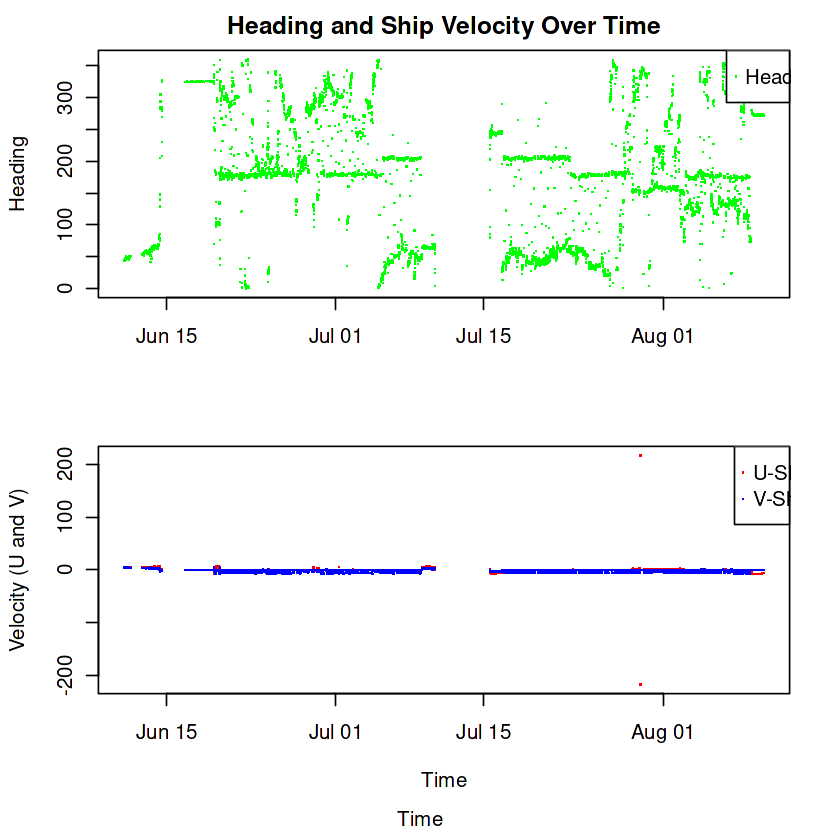

In [4]:
# Get the heading, uship, vship, and time variables
heading <- ncvar_get(dataset, "heading")
u_ship <- ncvar_get(dataset, "uship")
v_ship <- ncvar_get(dataset, "vship")
time_values <- ncvar_get(dataset, "time")

# Get time units and convert to POSIXct (as done previously)
time_units <- ncatt_get(dataset, "time", "units")$value
time <- NA
if (grepl("days since", time_units)) {
  origin_str <- sub("days since ", "", time_units)
  origin_date <- as.POSIXct(origin_str, tz = "UTC")
  time <- origin_date + time_values * 24 * 3600
} else if (grepl("hours since", time_units)) {
  origin_str <- sub("hours since ", "", time_units)
  origin_date <- as.POSIXct(origin_str, tz = "UTC")
  time <- origin_date + time_values * 3600
} else if (grepl("seconds since", time_units)) {
  origin_str <- sub("seconds since ", "", time_units)
  origin_date <- as.POSIXct(origin_str, tz = "UTC")
  time <- origin_date + time_values
} else {
  warning(paste("Unsupported time units:", time_units, ". Time plot may not be correct."))
  time <- time_values # Use raw values if conversion fails
}

# Create the plot
par(mfrow = c(2, 1), mar = c(4, 4, 2, 2) + 0.1, oma = c(2, 0, 0, 0)) # Set up a 2x1 plot layout

# Plot heading
plot(time, heading, pch = ".", col = "green",
     xlab = "", ylab = "Heading",
     main = "Heading and Ship Velocity Over Time")
legend("topright", legend = "Heading", pch = ".", col = "green")

# Plot u_ship and v_ship on the second subplot
plot(time, u_ship, pch = ".", col = "red",
     xlab = "Time", ylab = "Velocity (U and V)")
points(time, v_ship, pch = ".", col = "blue")
legend("topright", legend = c("U-Ship", "V-Ship"), pch = ".", col = c("red", "blue"))

mtext("Time", side = 1, outer = TRUE, line = 0.5) # Add a common x-axis label

# Reset the plotting parameters (optional)
par(mfrow = c(1, 1), mar = c(5, 4, 4, 2) + 0.1, oma = c(0, 0, 0, 0))

This gap corresponds to a start/stop event in the data.  

# 3. Time series comparison

A16S in year 2005
u_avg shape: , v_avg shape: , speed_avg shape: 
A16S in year 2005
u_avg shape: , v_avg shape: , speed_avg shape: 
A16S in year 2014
u_avg shape: , v_avg shape: , speed_avg shape: 
A16S in year 2014
u_avg shape: , v_avg shape: , speed_avg shape: 
A16S in year 2014
u_avg shape: , v_avg shape: , speed_avg shape: 
A16S in year 2014
u_avg shape: , v_avg shape: , speed_avg shape: 


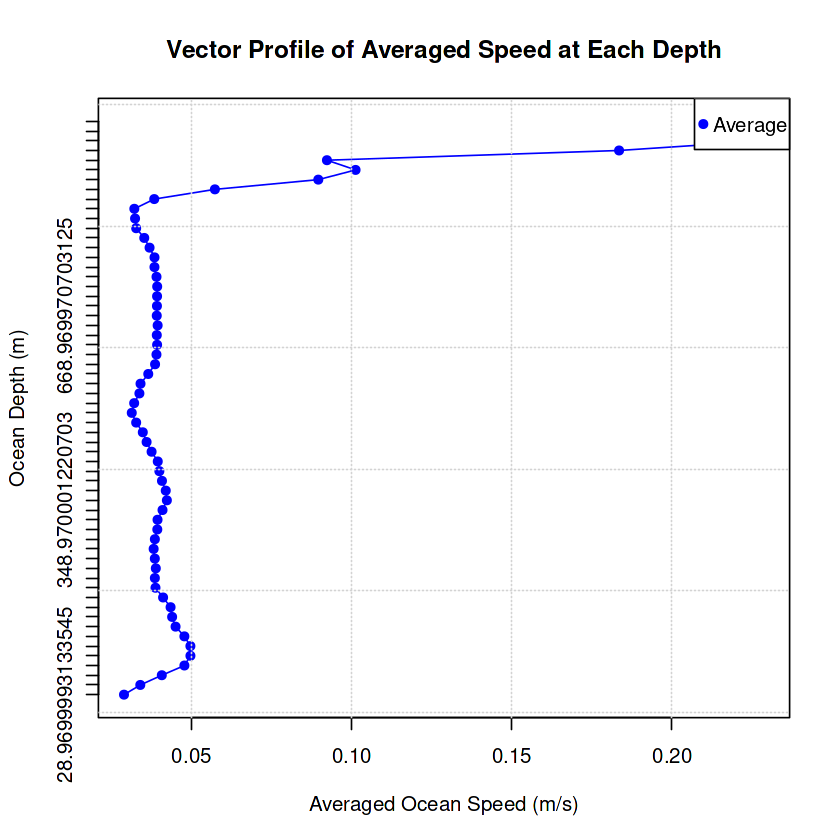

In [5]:
# Define the track to analyze
track <- 'A16S'

# Initialize lists to store results
speed_avgs <- list()
depth_list <- list()
profile_list <- list()

# Loop through the datasets_files list
for (data_glob in datasets_files) {
  # Assuming each element of datasets_files is a list:
  # [1] = NetCDF file object (from nc_open)
  # [2] = cruise_track (character)
  # [3] = year (character)
  # [4] = profile (character)

  if (length(data_glob) >= 4 && data_glob[[2]] == track) {
    cat(sprintf("%s in year %s\n", data_glob[[2]], data_glob[[3]]))

    dataset <- data_glob[[1]]

    # Get the u, v, depth, and time variables
    u <- ncvar_get(dataset, "u")
    v <- ncvar_get(dataset, "v")
    depth <- ncvar_get(dataset, "depth")
    time <- ncvar_get(dataset, "time")

    # Calculate the average u and v velocities over the time dimension
    u_avg <- rowMeans(u, na.rm = TRUE)
    v_avg <- rowMeans(v, na.rm = TRUE)

    # Calculate the average speed
    speed_avg <- sqrt(u_avg^2 + v_avg^2)

    # Store the results
    speed_avgs[[length(speed_avgs) + 1]] <- speed_avg
    cat(sprintf("u_avg shape: %s, v_avg shape: %s, speed_avg shape: %s\n",
                paste(dim(u_avg), collapse = " "),
                paste(dim(v_avg), collapse = " "),
                paste(dim(speed_avg), collapse = " ")))

    # Assuming depth is consistent across time and the first profile
    depth_list[[length(depth_list) + 1]] <- depth[,1] # Taking the first time step's depth
    profile_list[[length(profile_list) + 1]] <- data_glob[[4]]

    # Close the current dataset
    nc_close(dataset)
  }
}

# Now, let's make a single plot using the data from the last processed track
if (length(speed_avgs) > 0 && length(depth_list) > 0) {
  last_speed_avg <- speed_avgs[[length(speed_avgs)]]
  last_depth <- depth_list[[length(depth_list)]]

  plot(last_speed_avg, last_depth,
       type = "o", # "o" for points connected by lines
       pch = 16,   # Solid circle marker
       col = "blue",
       xlab = "Averaged Ocean Speed (m/s)",
       ylab = "Ocean Depth (m)",
       main = "Vector Profile of Averaged Speed at Each Depth",
       yaxt = "n") # Suppress default y-axis


  
  # Invert the y-axis
  axis(side = 2, at = rev(last_depth), labels = rev(last_depth))

  grid()
  legend("topright", legend = "Average Speed", pch = 16, col = "blue")
} else {
  cat("No data found for track", track, "\n")
}


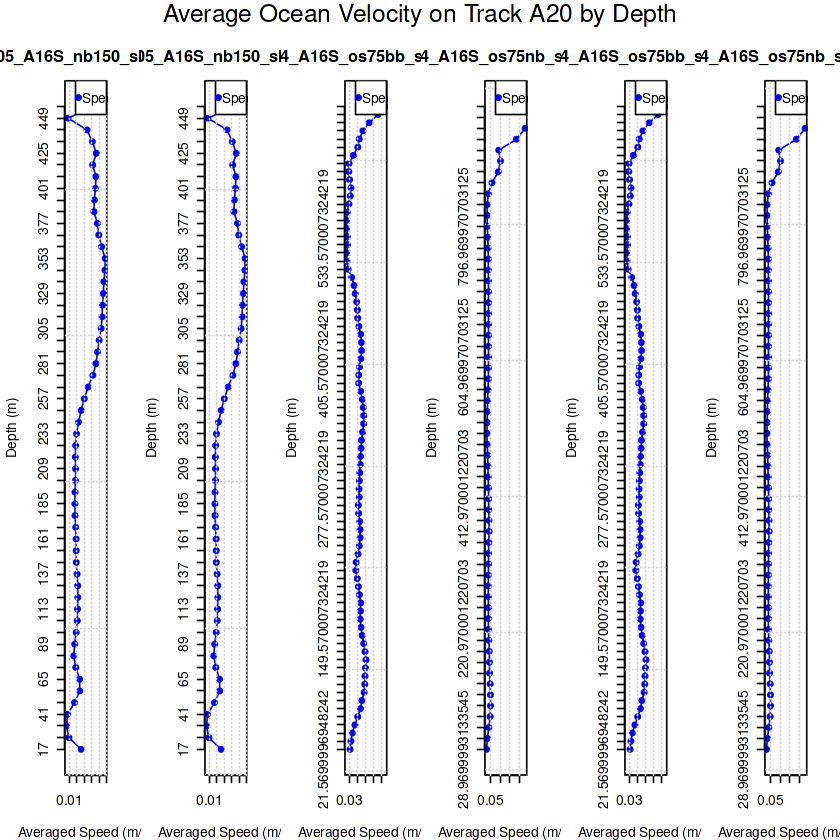

In [6]:
# Determine the number of plots
num_plots <- length(speed_avgs)

# Set up the plotting layout (adjust rows and columns as needed)
# Here, we'll try to put them in a single row if it fits reasonably
if (num_plots > 0) {
  par(mfrow = c(1, num_plots), mar = c(4, 4, 3, 2) + 0.1, oma = c(0, 0, 2, 0))

  # Iterate over each set of average speed, depth, and profile
  for (i in 1:num_plots) {
    avg_speed <- speed_avgs[[i]]
    depth <- depth_list[[i]]
    profile_name <- profile_list[[i]]

    # Create the plot
    plot(avg_speed, depth,
         type = "o", # "o" for points connected by lines
         pch = 16,   # Solid circle marker
         col = "blue",
         xlab = "Averaged Speed (m/s)",
         ylab = "Depth (m)",
         main = profile_name,
         yaxt = "n") # Suppress default y-axis

    # Invert the y-axis
    axis(side = 2, at = rev(depth), labels = rev(depth))

    grid()
    legend("topright", legend = paste("Speed Average"), pch = 16, col = "blue")
  }

  # Add a common title to the figure
  mtext(paste("Average Ocean Velocity on Track A20 by Depth"),
        side = 3, outer = TRUE, line = 0.5, cex = 1.2)

  # Reset plotting parameters
  par(mfrow = c(1, 1), mar = c(5, 4, 4, 2) + 0.1, oma = c(0, 0, 0, 0))

} else {
  cat("No data available in speed_avgs, depth_list, or profile_list to plot.\n")
}


 [1] "cruise_track_set :  A16N"  "cruise_track_set :  A20"  
 [3] "cruise_track_set :  A22"   "cruise_track_set :  P02"  
 [5] "cruise_track_set :  A16S"  "cruise_track_set :  P16S" 
 [7] "cruise_track_set :  P16N"  "cruise_track_set :  I8S"  
 [9] "cruise_track_set :  I9N"   "cruise_track_set :  P18"  
[11] "cruise_track_set :  I6S"   "cruise_track_set :  I5"   
[13] "cruise_track_set :  P06"   "cruise_track_set :  A13p5"
[15] "cruise_track_set :  A10"   "cruise_track_set :  S04P" 
[17] "cruise_track_set :  P02E"  "cruise_track_set :  P02W" 
[19] "cruise_track_set :  ARC01" "cruise_track_set :  I08S" 
[21] "cruise_track_set :  I09N"  "cruise_track_set :  P06E" 
[23] "cruise_track_set :  P06W"  "cruise_track_set :  I06S" 
[25] "cruise_track_set :  I05"  


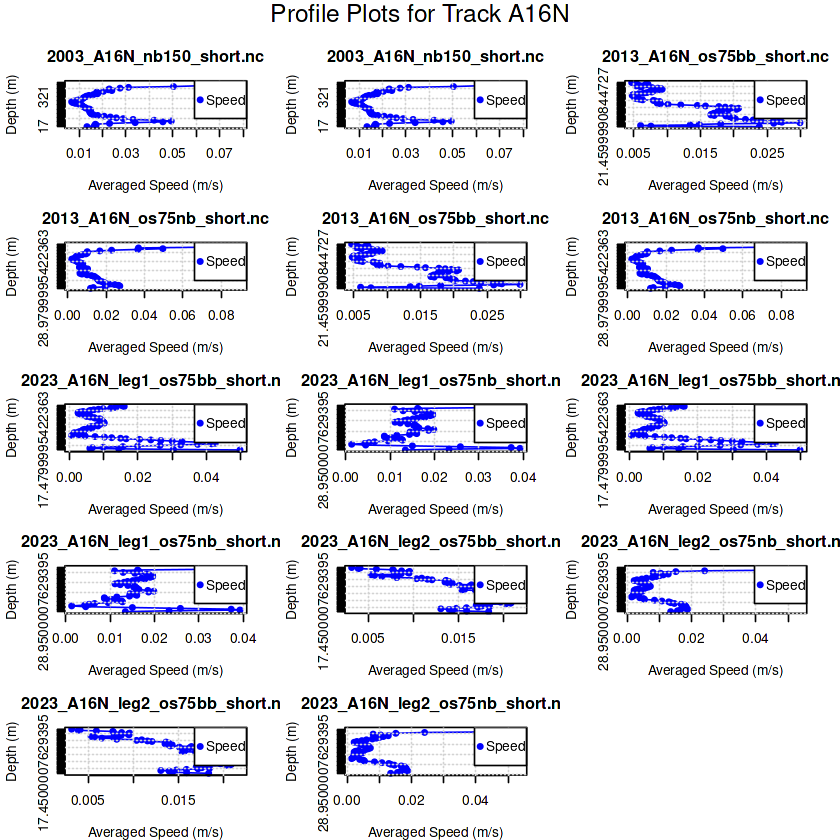

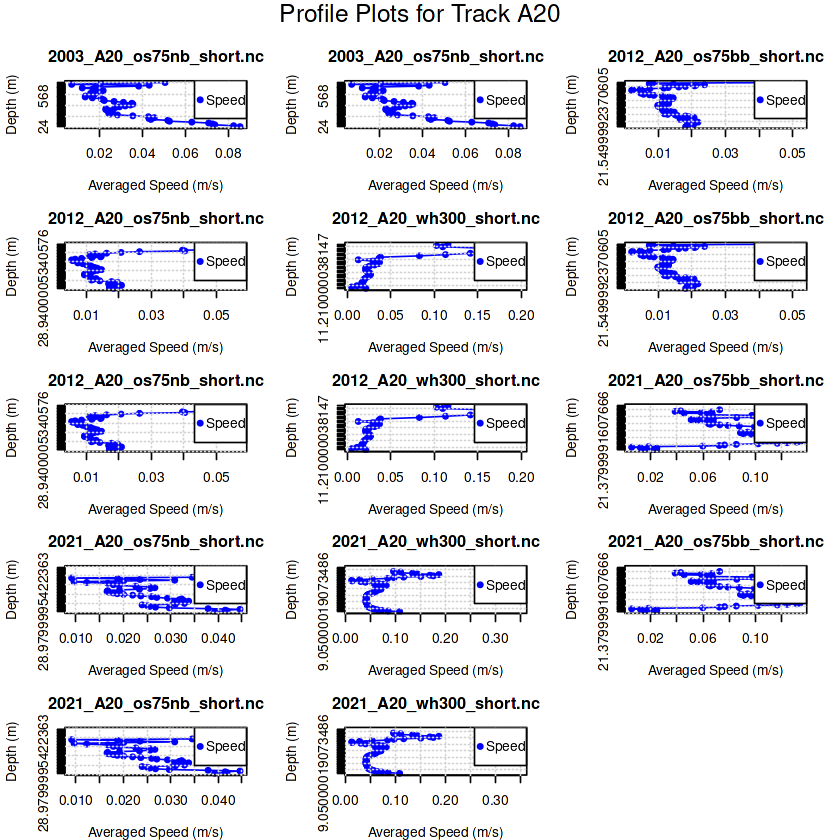

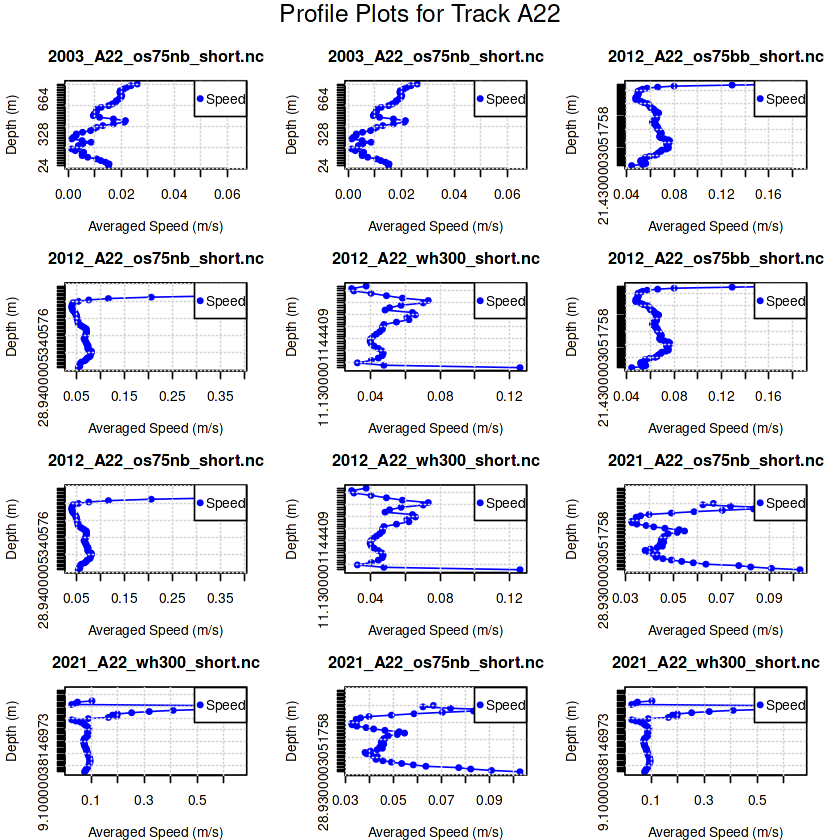

Error in R_nc4_inq_varndims: NetCDF: Not a valid ID
Runtime error on 2005_A16S_nb150_short.nc: error returned from C call
Error in R_nc4_close: NetCDF: Not a valid ID
Error in R_nc4_inq_varndims: NetCDF: Not a valid ID
Runtime error on 2005_A16S_nb150_short.nc: error returned from C call
Error in R_nc4_close: NetCDF: Not a valid ID
Error in R_nc4_inq_varndims: NetCDF: Not a valid ID
Runtime error on 2014_A16S_os75bb_short.nc: error returned from C call
Error in R_nc4_close: NetCDF: Not a valid ID
Error in R_nc4_inq_varndims: NetCDF: Not a valid ID
Runtime error on 2014_A16S_os75nb_short.nc: error returned from C call
Error in R_nc4_close: NetCDF: Not a valid ID
Error in R_nc4_inq_varndims: NetCDF: Not a valid ID
Runtime error on 2014_A16S_os75bb_short.nc: error returned from C call
Error in R_nc4_close: NetCDF: Not a valid ID
Error in R_nc4_inq_varndims: NetCDF: Not a valid ID
Runtime error on 2014_A16S_os75nb_short.nc: error returned from C call
Error in R_nc4_close: NetCDF: Not a val

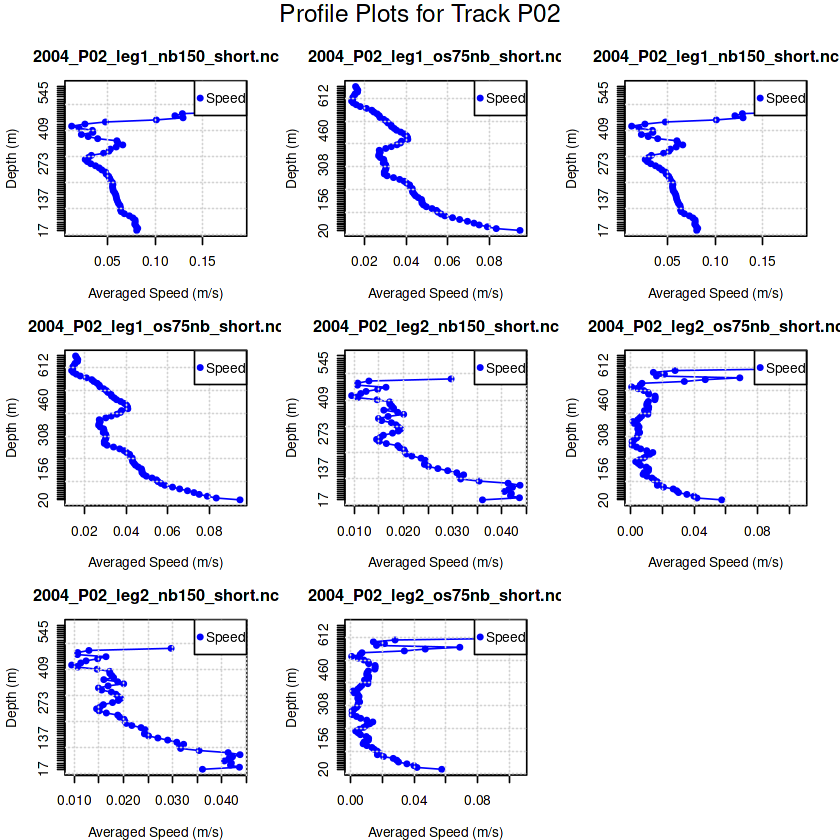

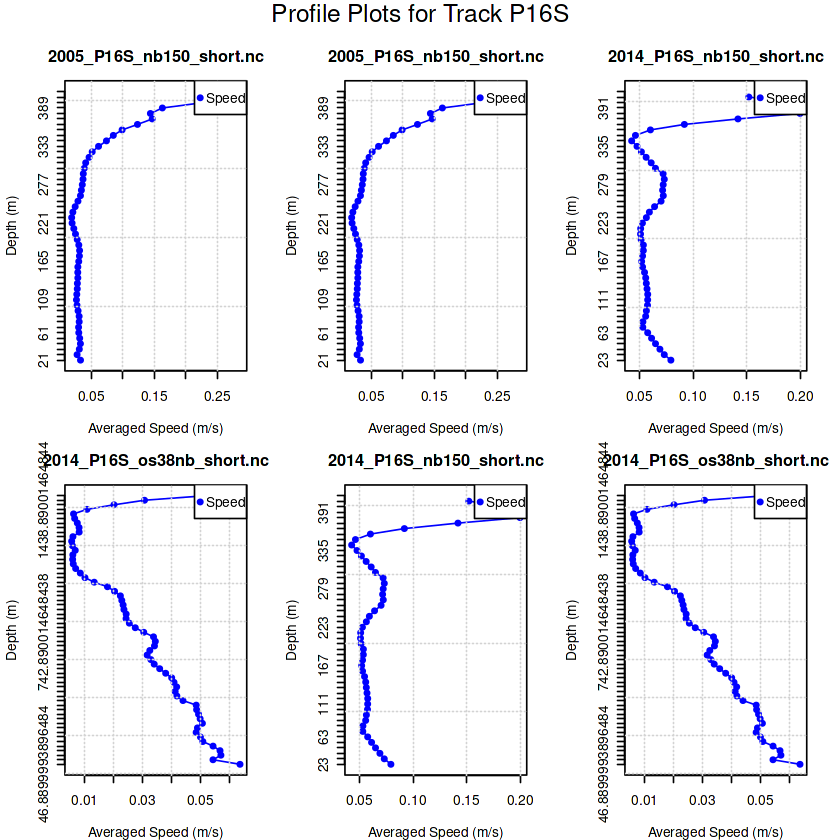

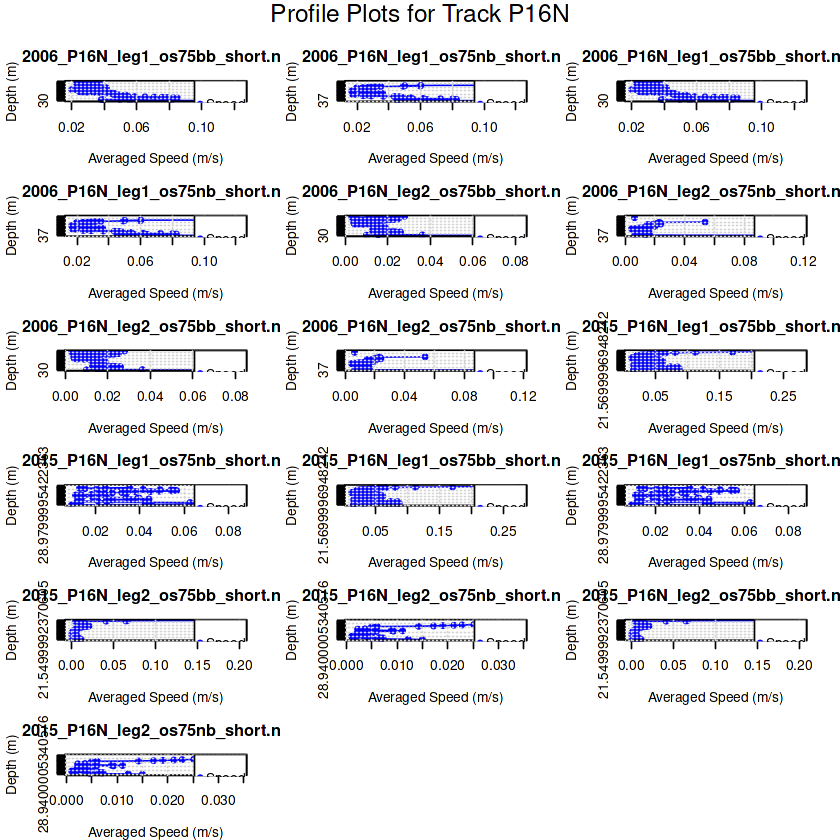

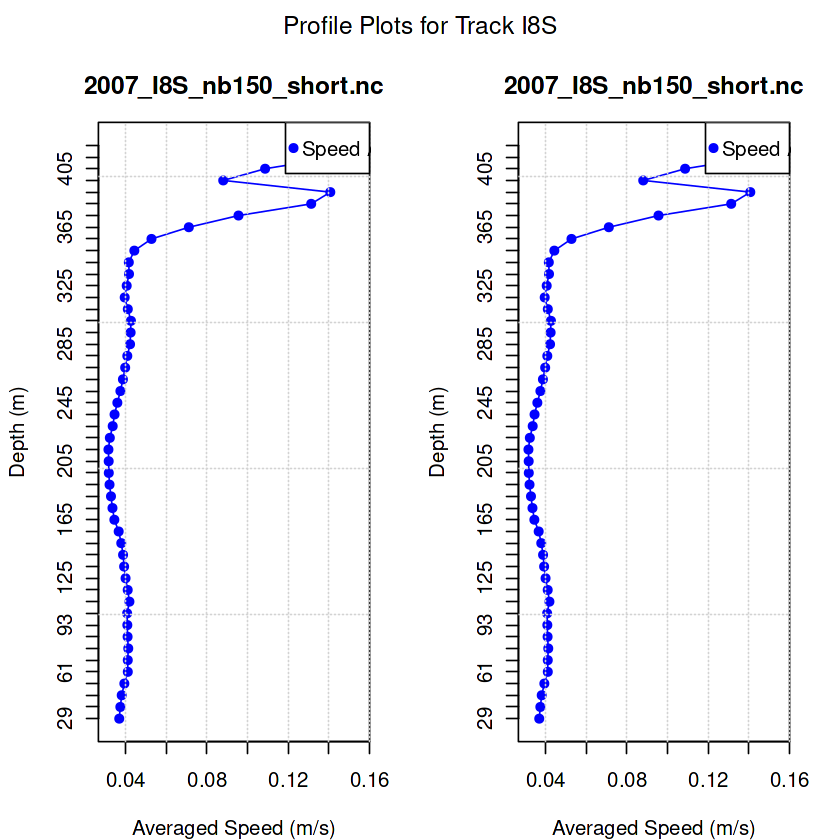

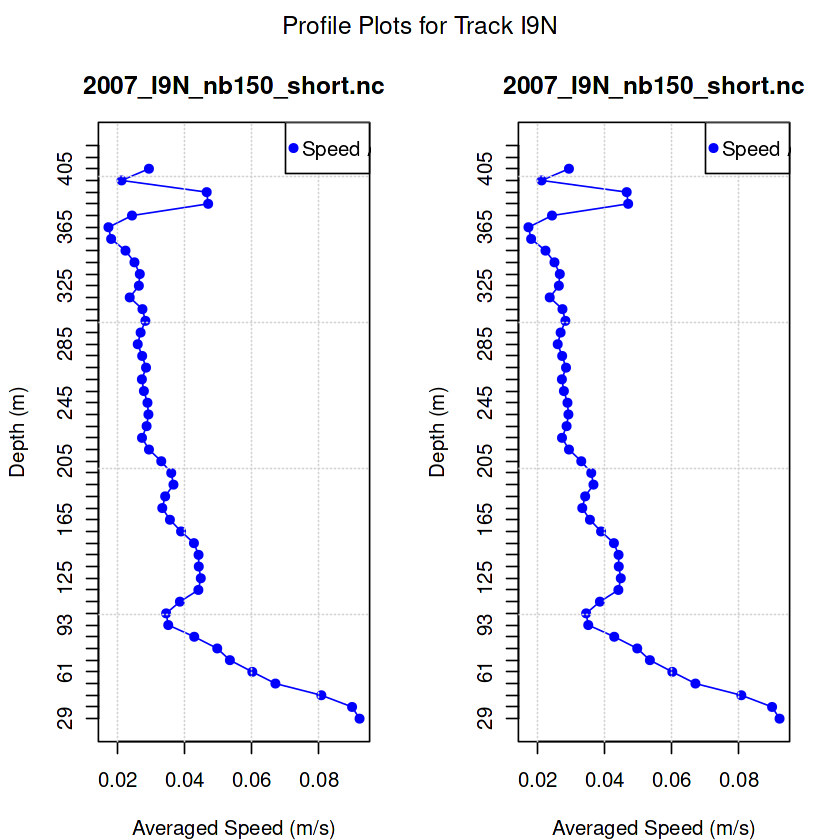

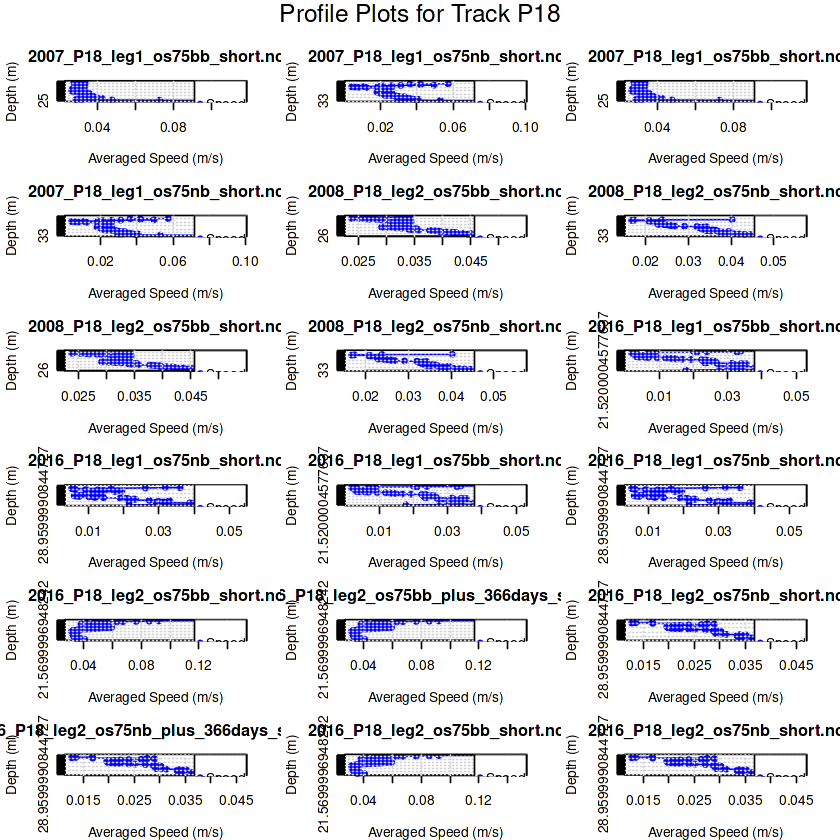

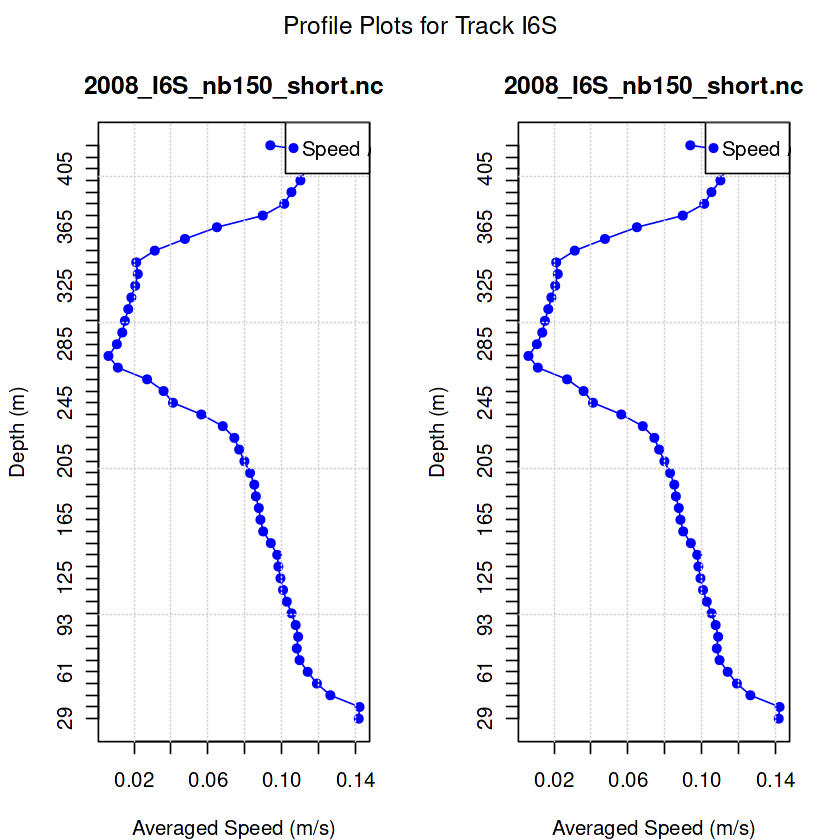

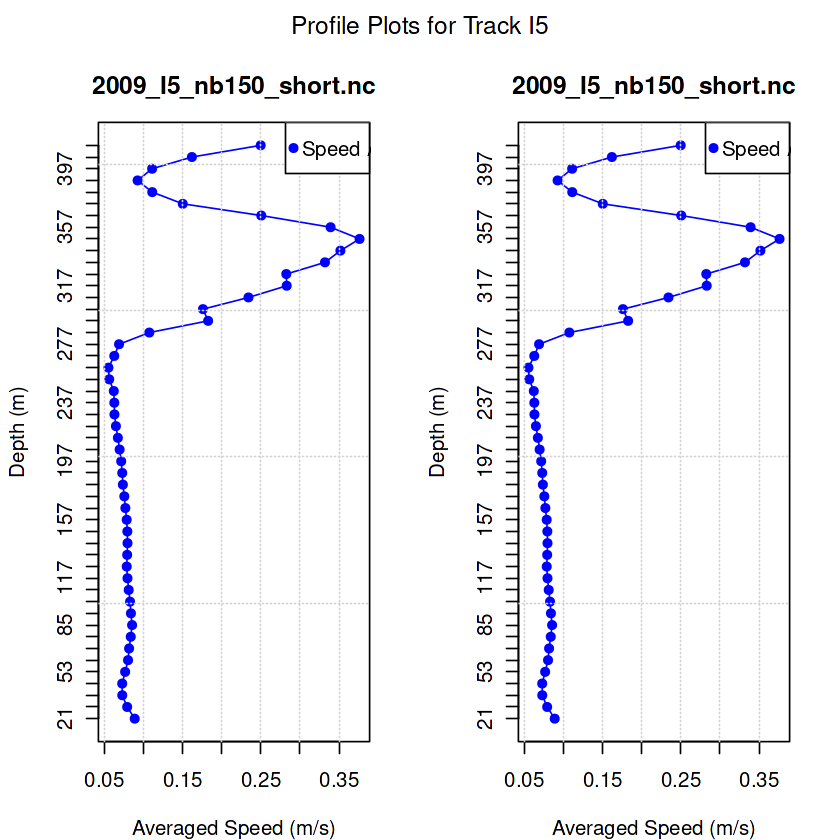

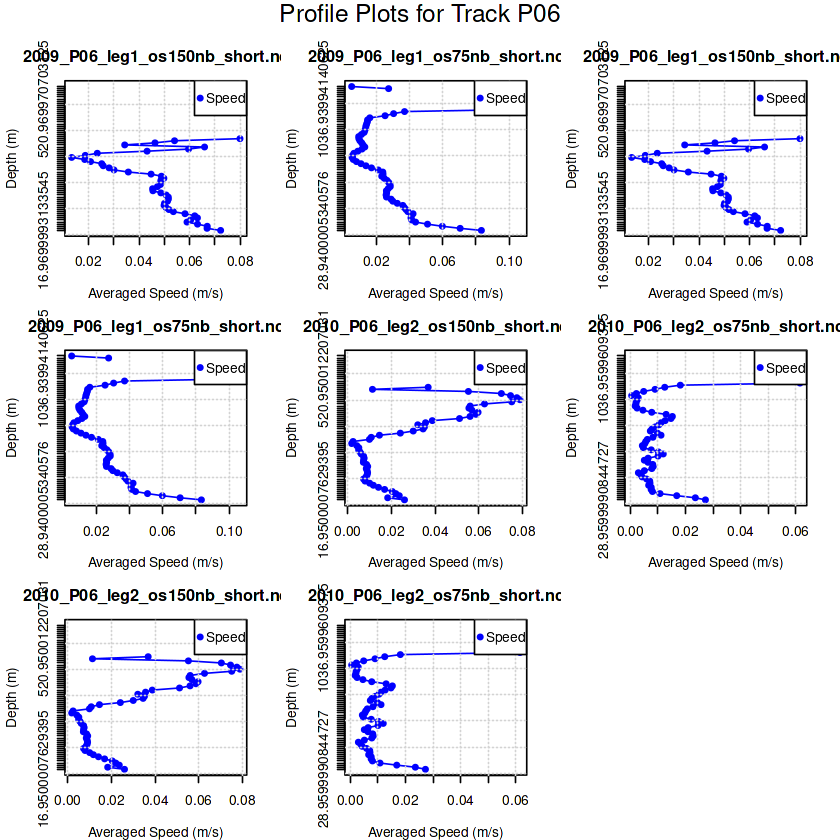

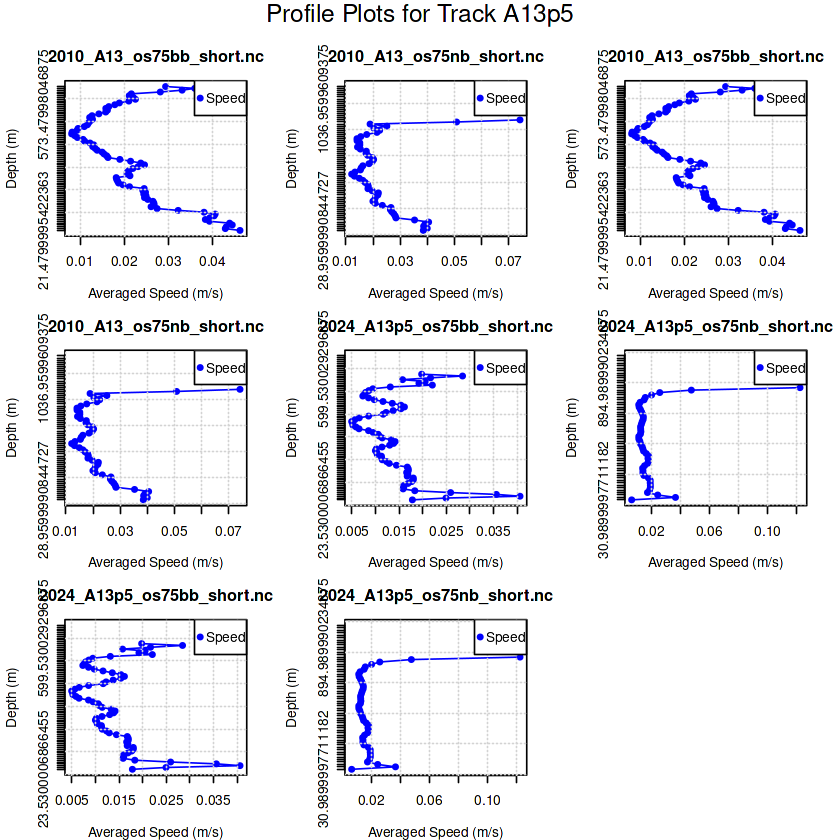

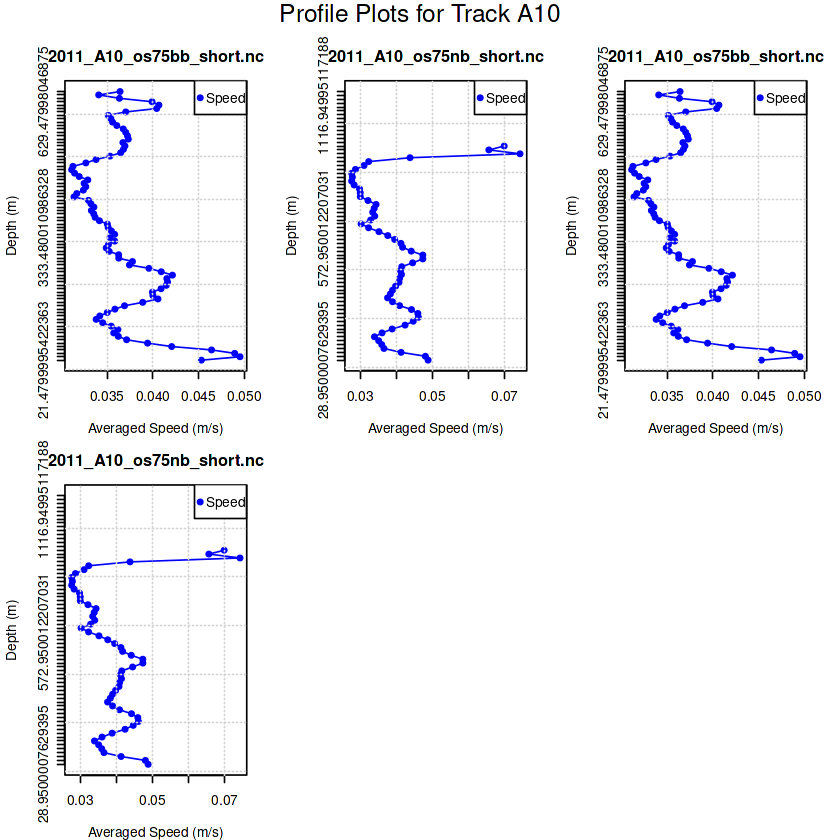

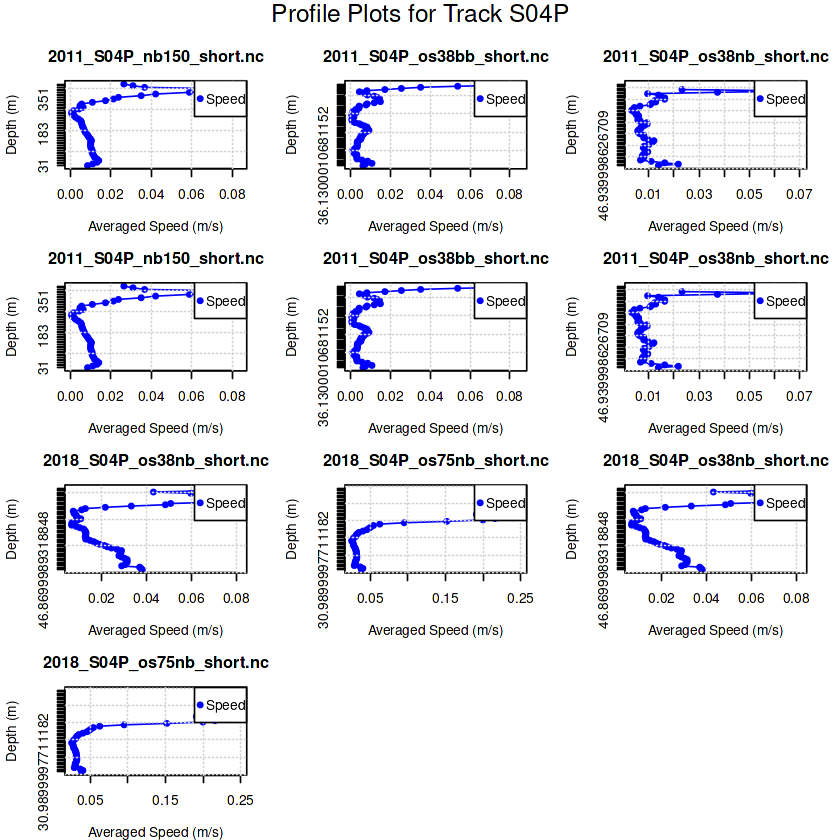

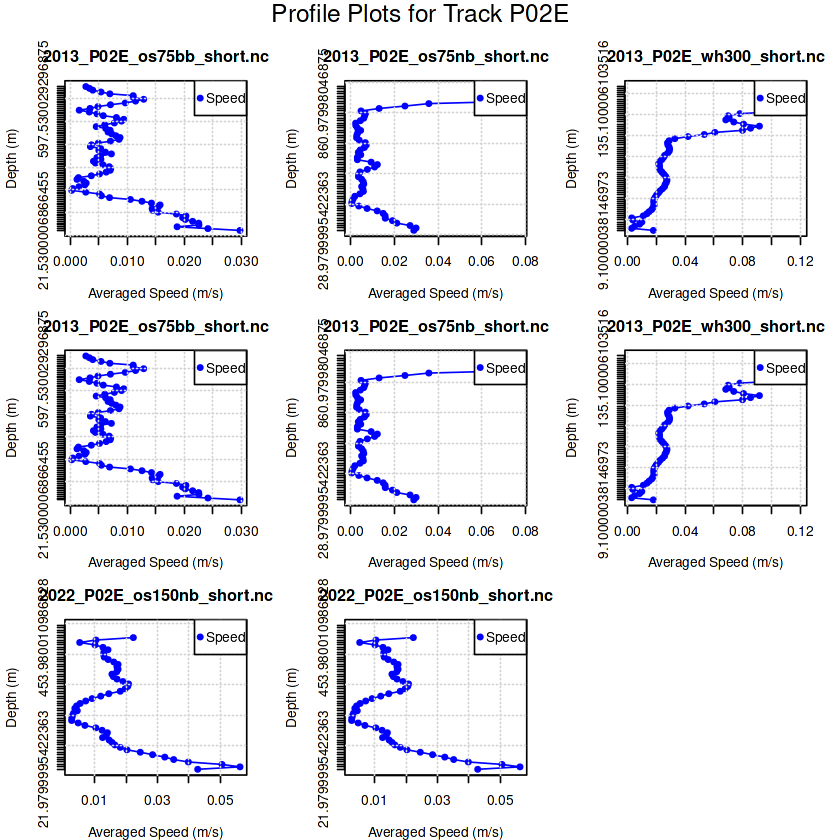

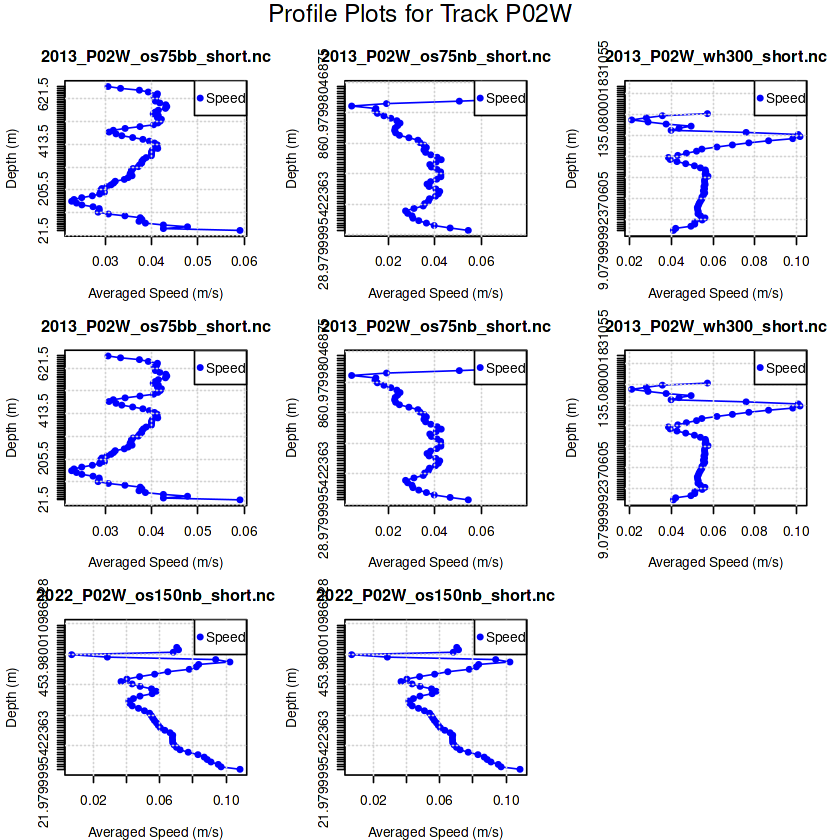

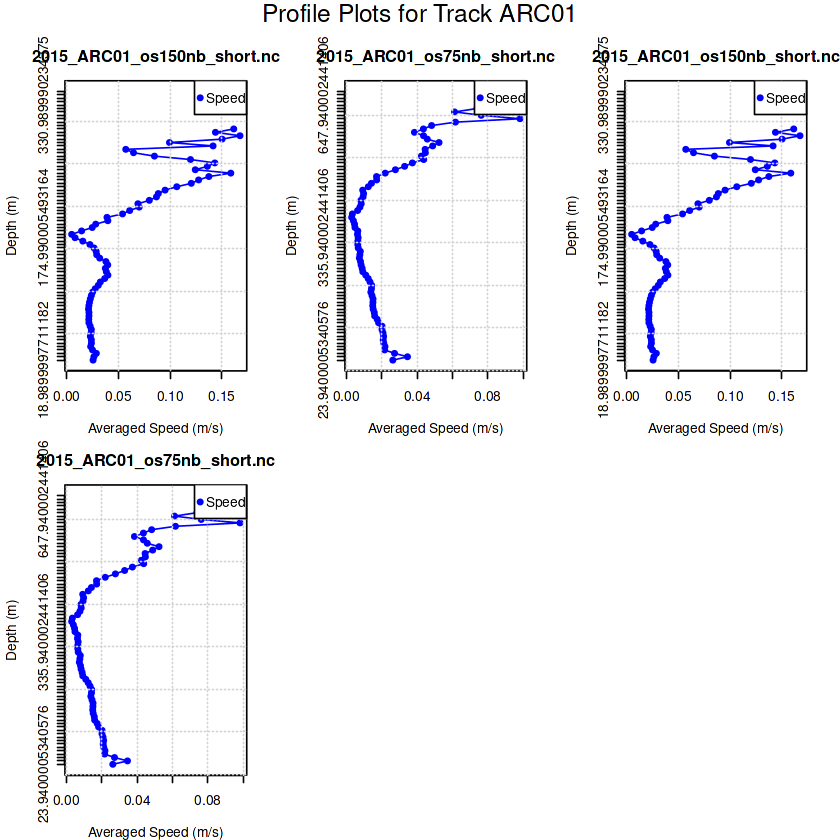

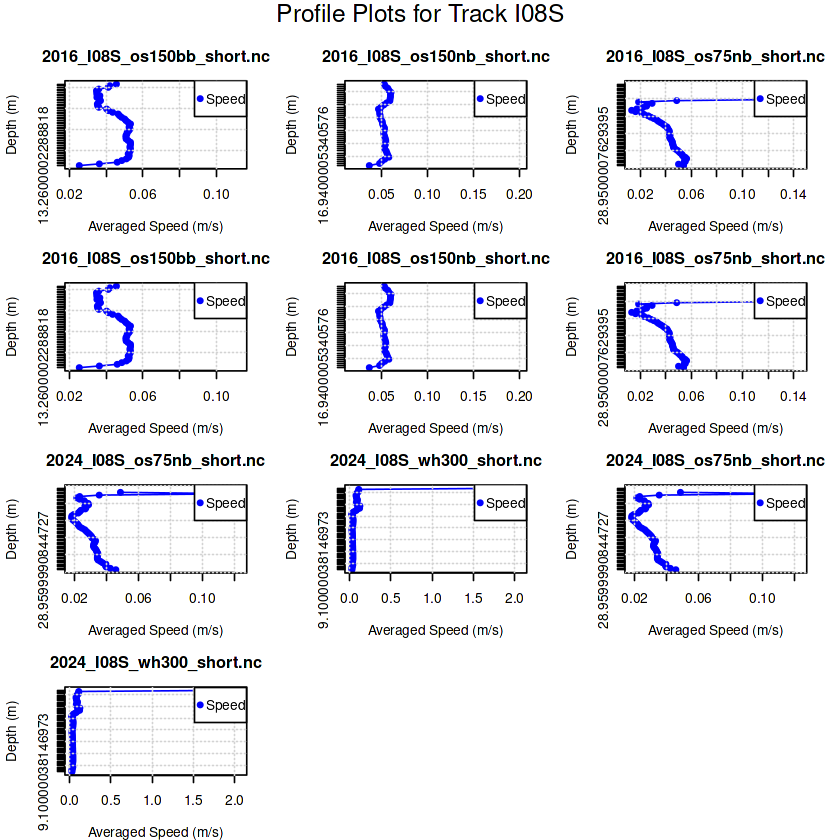

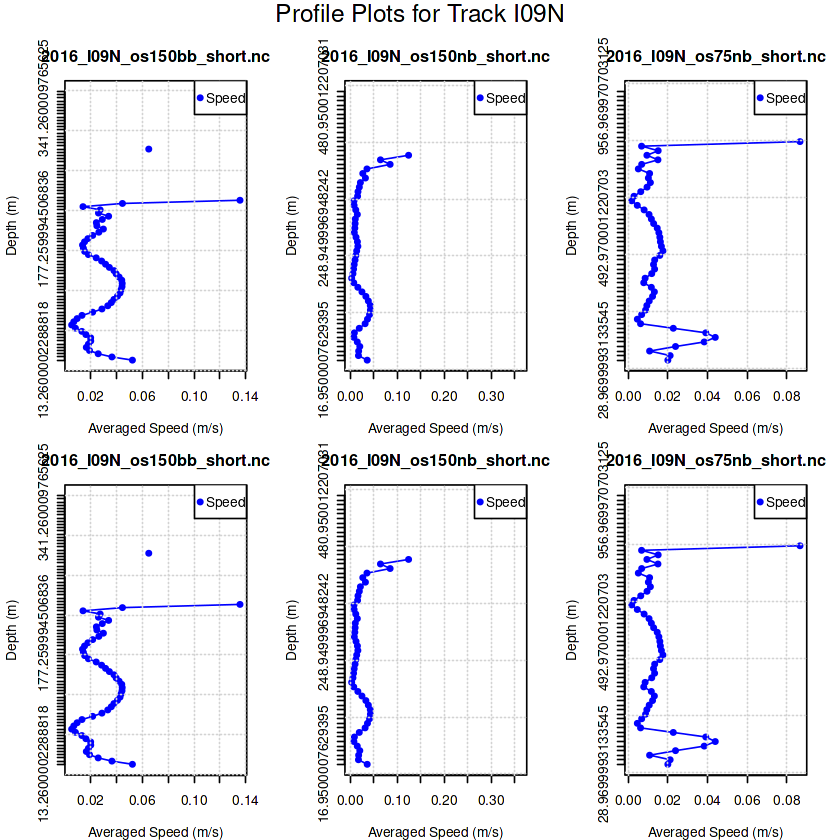

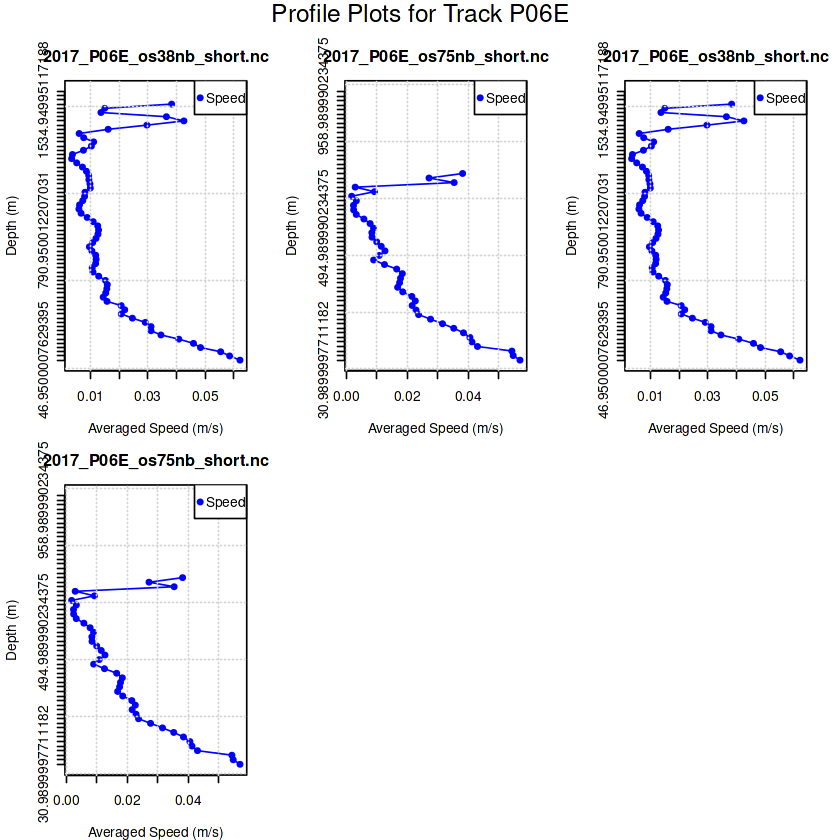

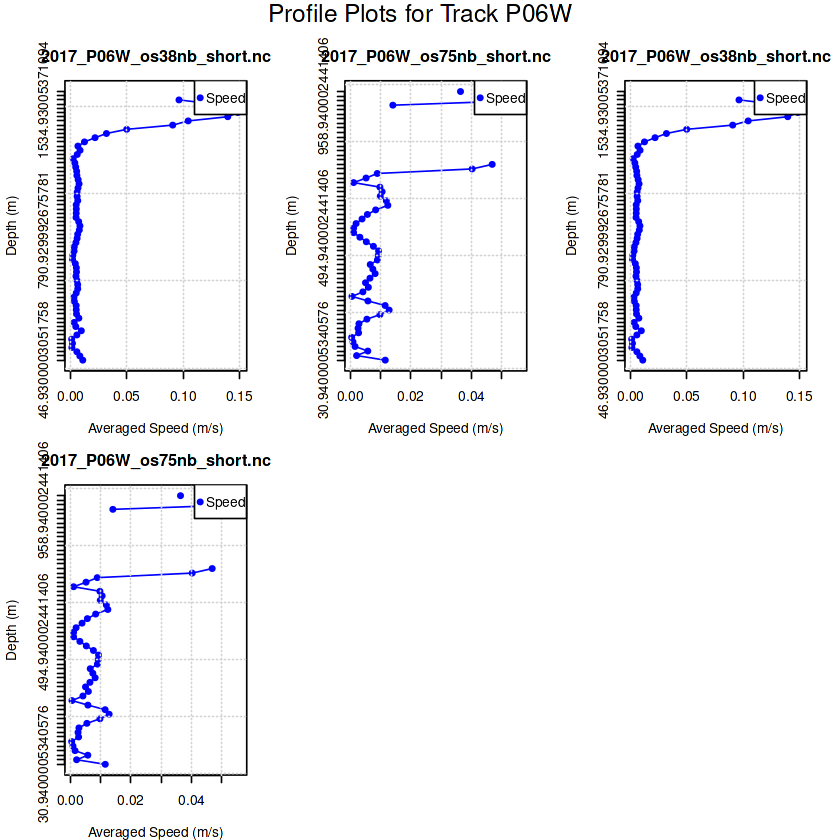

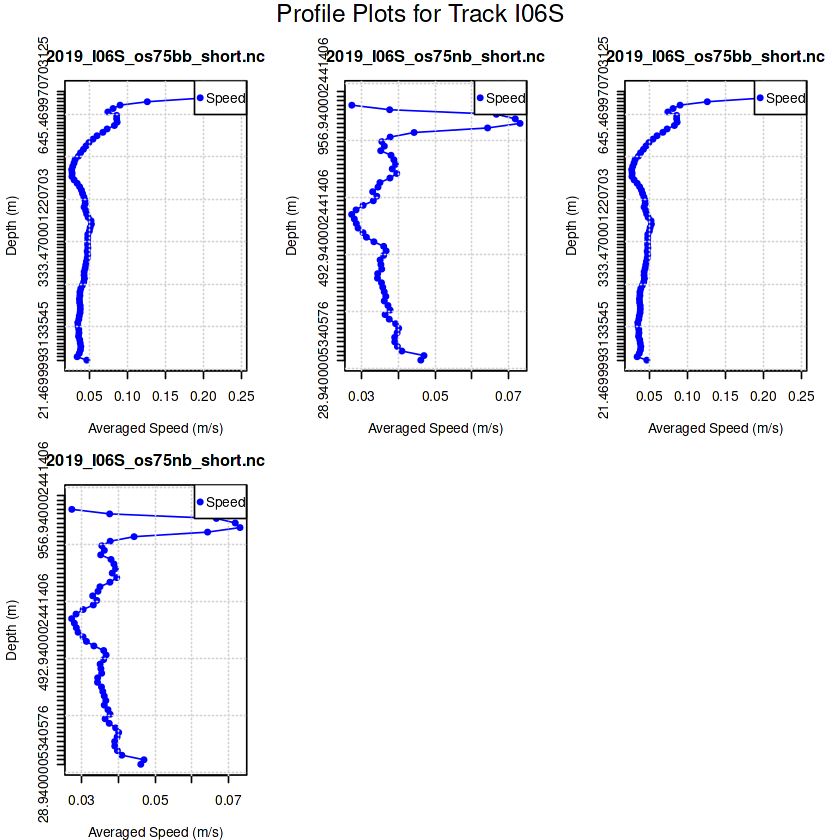

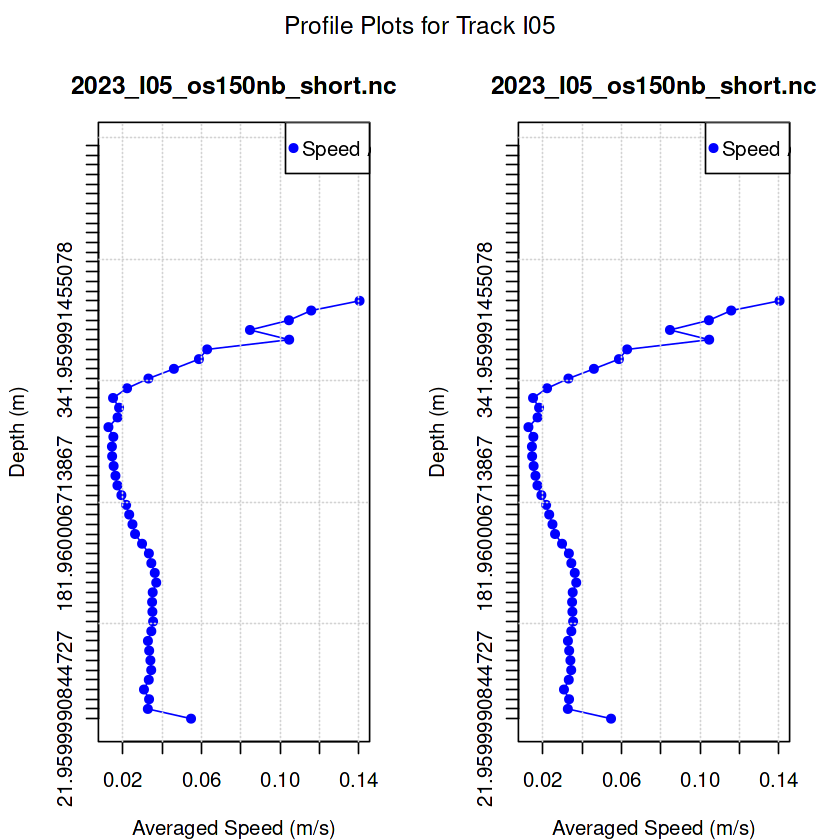

In [7]:
print(paste("cruise_track_set : ", cruise_track_set))
# Get unique cruise tracks
cruise_track_set <- unique(sapply(datasets_files, function(x) x[[2]]))

# Iterate through each cruise track
for (track in cruise_track_set) {
  speed_avgs <- list()   # List to store speed averages for each profile
  depth_list <- list()   # List to store depth for each profile
  profile_list <- list() # List to store profile names for titles

  # Collect data for each profile in the current track
  for (data_glob in datasets_files) {
    if (length(data_glob) >= 4 && data_glob[[2]] == track) {
      # cat(sprintf("%s in year %s\n", data_glob[[2]], data_glob[[3]]))

      dataset <- data_glob[[1]]

      # Try to get the 'u' variable, skip if there's an error
      u <- tryCatch(ncvar_get(dataset, "u"),
                    error = function(e) {
                      cat(sprintf("Runtime error on %s: %s\n", data_glob[[4]], e$message))
                      return(NULL)
                    })

      if (is.null(u)) {
        nc_close(dataset)
        next # Skip to the next dataset
      }

      v <- ncvar_get(dataset, "v")
      depth <- ncvar_get(dataset, "depth")
      time <- ncvar_get(dataset, "time")

      # Calculate the average u and v velocities over the time dimension
      # Assuming the time dimension is the first dimension
      u_avg <- rowMeans(u, na.rm = TRUE)
      v_avg <- rowMeans(v, na.rm = TRUE)


      # Calculate the speed magnitude at each depth
      speed_avg <- sqrt(u_avg^2 + v_avg^2)

      # Append results for this dataset (this profile)
      speed_avgs[[length(speed_avgs) + 1]] <- speed_avg
      depth_list[[length(depth_list) + 1]] <- depth[,1] # Assuming depth is consistent
      profile_list[[length(profile_list) + 1]] <- data_glob[[4]]

      # Close the current dataset
      nc_close(dataset)
    }
  }

  # Create panel plots for each track
  num_profiles <- length(speed_avgs)
  if (num_profiles == 0) {
    cat(sprintf("Skipped %s: No data found for this track.\n", track))
    next
  }

  # Determine the number of columns for the plot layout
  num_cols <- num_profiles
  if (num_cols > 3) {
    num_cols <- 3 # Adjust as needed for better visualization
  }
  num_rows <- ceiling(num_profiles / num_cols)

  # Set up the plotting layout
  par(mfrow = c(num_rows, num_cols), mar = c(4, 4, 3, 2) + 0.1, oma = c(0, 0, 2, 0))

  # Plot each profile in a subplot
  for (i in 1:num_profiles) {
    avg_speed <- speed_avgs[[i]]
    depth <- depth_list[[i]]
    profile_name <- profile_list[[i]]

    plot(avg_speed, depth,
         type = "o",
         pch = 16,
         col = "blue",
         xlab = "Averaged Speed (m/s)",
         ylab = "Depth (m)",
         main = profile_name,
         yaxt = "n")
    axis(side = 2, at = rev(depth), labels = rev(depth))
    grid()
    legend("topright", legend = "Speed Average", pch = 16, col = "blue")
  }

  # Add a common title for the set of subplots for this track
  mtext(paste("Profile Plots for Track", track),
        side = 3, outer = TRUE, line = 0.5, cex = 1.2)

  # Reset plotting parameters
  par(mfrow = c(1, 1), mar = c(5, 4, 4, 2) + 0.1, oma = c(0, 0, 0, 0))
}